In [1]:
import numpy as np
from common.image_preprocessing import data_all, data_temp, temp_from_original
from pathlib import Path, PurePath
import time

sz = 128
temp_relative_path = PurePath(f"{sz}x{sz}") / 'clahe_processed'
eevorg_temp = data_temp / 'eevorg' / temp_relative_path
processed_imgs = {}

start_time = time.time()
for npy_filepath in eevorg_temp.glob('*.npy'):
    img = np.load(npy_filepath)
    img = np.reshape(img, (img.shape[0],img.shape[1],1))
    processed_imgs[npy_filepath.stem] = img
    if len(processed_imgs) % 100 == 0:
        print(npy_filepath.stem, img.shape, end='\r')
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

image_processing: DATA_ALL=G:\DataAll; DATA_TEMP=E:\Data\zebtrastack_temp
Loaded 10294 npy in 5.182033538818359 seconds


In [7]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

Training data has shape (9265, 128, 128, 1)
Testing data has shape (1029, 128, 128, 1)


In [11]:
from cxr_projection.zebrastack_v0_model import create_encoder, create_decoder, create_autoencoder
retina, encoder, shape, [z_mean, z_log_var, z] = create_encoder()
decoder = create_decoder(shape)
autoencoder = create_autoencoder(retina, encoder, [z_mean, z_log_var, z], decoder)

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [12]:
autoencoder.fit(x_train, x_train, 
                epochs=128, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Train on 9265 samples, validate on 1029 samples
Epoch 1/128
9265/9265 [==============================] - 15s 2ms/step - loss: 751.0325 - val_loss: 1085.4932
Epoch 2/128
9265/9265 [==============================] - 10s 1ms/step - loss: 497.8546 - val_loss: 1029.8426
Epoch 3/128
9265/9265 [==============================] - 10s 1ms/step - loss: 488.8190 - val_loss: 1178.0357
Epoch 4/128
9265/9265 [==============================] - 10s 1ms/step - loss: 480.0111 - val_loss: 1076.2413
Epoch 5/128
9265/9265 [==============================] - 10s 1ms/step - loss: 477.8526 - val_loss: 1040.6335
Epoch 6/128
9265/9265 [==============================] - 10s 1ms/step - loss: 472.7178 - val_loss: 913.5156
Epoch 7/128
9265/9265 [==============================] - 10s 1ms/step - loss: 472.9876 - val_loss: 1136.9281
Epoch 8/128
9265/9265 [==============================] - 11s 1ms/step - loss: 469.8711 - val_loss: 1026.5804
Epoch 9/128
9265/9265 [==============================] - 10s 1ms/step - loss: 470

9265/9265 [==============================] - 10s 1ms/step - loss: 464.3390 - val_loss: 1038.2755
Epoch 76/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.5904 - val_loss: 1077.4474
Epoch 77/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.2330 - val_loss: 1015.9259
Epoch 78/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.4810 - val_loss: 1058.3725
Epoch 79/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.3962 - val_loss: 981.5174
Epoch 80/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.6561 - val_loss: 1034.4543
Epoch 81/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.6620 - val_loss: 1046.0365
Epoch 82/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.3989 - val_loss: 1047.6707
Epoch 83/128
9265/9265 [==============================] - 10s 1ms/step - loss: 464.4180 - val_loss: 1045.1025
Epoch 84/128
9265/9265 [

In [13]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

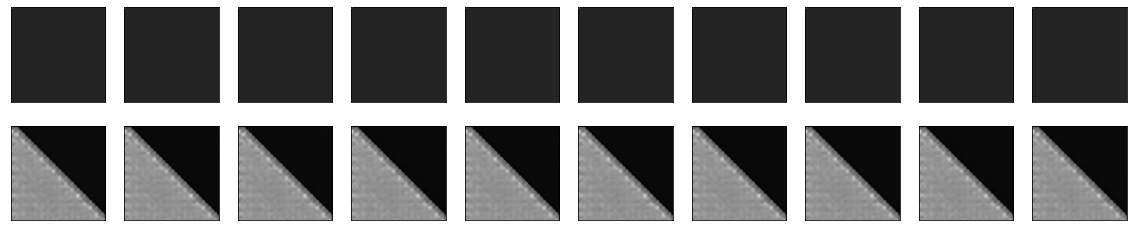

In [14]:
from cxr_projection.show_original_decoded import show_grayscale, show_original_decoded

encode_only_imgs = encoder.predict(x_test[:10])
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)